# Functions in project 2

In [52]:
import keyboard
import time
import wave
import pyaudio
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    # first divide signal into 10ms segments
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments

# Preemphasize each segement
def Preemphasizing(segment):
    pre=np.zeros(len(segment))
    pre[0]=segment[0]
    for i in range(1,len(segment)):
        pre[i]=segment[i]-0.95*segment[i-1]
    return pre

# Window each preemphasized segement
def windowing(pre):
    pre=pre*np.hamming(len(pre))
    return pre

# Zero pad each windowed segement
def zero_padding(windowed):
    #zero padding for FFT
    length=512
    windowed_len=len(windowed)
    padding_len=length-windowed_len
    zeros=np.zeros((padding_len,))
    zero_padded=np.concatenate((windowed,zeros))
    return zero_padded

# Calculate the power spectrum of a segement
def FFT(frame):
    length=512
    fft=np.fft.rfft(frame, length)
    magnitude = np.abs(fft)
    power = ((1.0 / length) * ((magnitude) ** 2)) 

    return power

# Mel warping function
def warping_function(Hz):
    Mel = 2595 * np.log10(1+Hz/700)
    return Mel
# inverse function
def inverse_warping(Mel):
    Hz = 700*(np.power(10,Mel/2595)-1) 
    return Hz

# calculate mel spectra and log mel spectra
def filterbanks(power,filter_num,minHz=133.33,maxHz=6855.4976,length=512):
    maxMel=warping_function(maxHz)
    minMel=warping_function(minHz)
    #get start and end points of triangle filters in Mel
    pointsInMel=np.linspace(minMel,maxMel,filter_num+2)
    #get start and end points of triangle filters in Hz
    pointsInHz=inverse_warping(pointsInMel)
    #get start and end points of tiangle filters in total 257 points
    ranges=np.floor(length/2*pointsInHz/(maxHz-minHz))
    #normalize the triangle filters according to the lower bound
    ranges=ranges-ranges[0]
    #create filter banks with size(number of filters=40, points in power spectrum=257)
    filter_banks=np.zeros((filter_num,len(power)))
    for i in range(1,filter_num+1): 
        #get the left half of the traingle
        for j in range(int(ranges[i-1]),int(ranges[i])):
            filter_banks[i-1,j]=(j-ranges[i-1])/(ranges[i]-ranges[i-1])
        #get the right half of the traingle
        for j in range(int(ranges[i]),int(ranges[i+1])):
            filter_banks[i-1,j]=(ranges[i+1]-j)/(ranges[i+1]-ranges[i])
    #mel spectrum
    filter_banks=filter_banks.T
    Mel=np.dot(power,filter_banks)
    Mel=np.where(Mel==0,np.finfo(float).eps,Mel)
    #log mel spectrum
    Log_Mel=10*np.log(Mel) 
    return Mel,Log_Mel

from scipy.fftpack import dct,idct
# use dct to get the cepstral_coefficients
def mel_cepstrum(log_mel):
    cepstral_coefficients=dct(log_mel,axis=-1, type=2, norm='ortho')
    return cepstral_coefficients[:13]

# get idct
def IDCT(log_mel,num):
    IDCT_coefficients=idct(log_mel,type=2, n=num, norm='ortho')
    return IDCT_coefficients

# get log mel spectrum matrix, mel cpestrum matrix and idct matrix, given segments
def get_matrix(segments,num):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    IDCT_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum,num)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
        IDCT_spectrum=IDCT(Mel_cepstrum,num)
        IDCT_matrix.append(IDCT_spectrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix,IDCT_matrix
#plot the spectrum and cepstrum
def plot_show(matrix, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(311)
    plt.imshow(matrix.T, origin='lower')
    plt.title(title)

#load wav file
def load_wav(file_path):
    wav_file = wave.open(file_path, 'r')
    # Get the audio data
    frames = wav_file.readframes(-1)
    signal = np.frombuffer(frames, dtype=np.int16)

    # Get the sample rate and time axis
    sample_rate = wav_file.getframerate()
    duration = len(signal) / sample_rate
    time = np.linspace(0., duration, len(signal))
    
    # Close the WAV file
    wav_file.close()
    return signal, sample_rate

# Problem 1

## 1. Mean subtraction and variance normalization

In [53]:
def mean_subtraction(matrix):
    means = np.mean(matrix, axis=0)/(np.shape(matrix)[0])
    matrix=matrix-means
    return matrix

def var_normalization(matrix):
    sd=np.sqrt(np.sum(np.square(matrix),axis=0)/(np.shape(matrix)[0]))
    return matrix*(1/sd)

## Get cepstrum feature

In [54]:
def get_cepstrum_features(file):
    signal, sample_rate=load_wav(file)
    seg=create_segments(signal,sample_rate)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=get_matrix(seg,40)
    log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix),np.array(IDCT_matrix)

    mean_subtracted=mean_subtraction(mel_cepstrum_matrix)
    var_normalized=var_normalization(mean_subtracted)
    return var_normalized

## 2. DTW

In [55]:
# calculate the Euclidean distance between two feature vectors
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def DTW(input, template):       
    new_array=np.full(len(template),np.inf)
    old_array=np.full(len(template),np.inf)
    for i in range(len(input)):
        if i==0:
            old_array[0]=euclidean_distance(input[i],template[0])
        else:
            for j in range(len(template)):
                if j==0:
                    new_array[0]=old_array[0]+euclidean_distance(input[i], template[j])
                elif j==1:
                    cost=min(old_array[j-1],old_array[j])
                    new_array[1]=euclidean_distance(input[i],template[j])+cost
                else:
                    cost=min(old_array[j-1],old_array[j-2],old_array[j])
                    new_array[j]=euclidean_distance(input[i],template[j])+cost
            old_array=new_array
            new_array=np.full(len(template),np.inf)
            
    # Return the DTW distance
    return old_array[len(template)-1]

In [86]:
template_feature_matrix=[]
for i in range(10):
    template_feature=get_cepstrum_features(str(i)+'_template.wav')
    template_feature_matrix.append(template_feature)
dtw_result=np.zeros((10,2))

def DTW_recognition(templates):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            dtw=DTW(training_feature,templates[0])
            type=0
            for k in range(1,10):
                cur_dtw=DTW(training_feature,template_feature_matrix[k])
                if cur_dtw<dtw:
                    dtw=cur_dtw
                    type=k
            result[i][j-1]=type
    return result

## Simple DTW accuracy

In [6]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
dtw_result=DTW_recognition(template_feature_matrix)
print(dtw_result)
differing_positions = dtw_result != correct_classifications
print('DTW Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0.]
 [4. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
DTW Accuracy: 0.95
Runtime: 16.088831 seconds


## 3. Time-synchronous DTW

In [7]:
def Time_synchronous_DTW(input,templates):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1):
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
        else:
            for k in range(len(template_len)-1):
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    new_array[j]=euclidean_distance(templates[k][j-low],input[i])+cost
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)
            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type
        


In [8]:
def TS_DTW_recognition(templates):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            type=Time_synchronous_DTW(training_feature,templates)
            result[i][j-1]=type
    return result

## Time-synchronous DTW Accuracy

In [9]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
ts_dtw_result=TS_DTW_recognition(template_feature_matrix)
print(ts_dtw_result)
differing_positions = ts_dtw_result != correct_classifications
print('TS_DTW Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0.]
 [4. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
TS_DTW Accuracy: 0.95
Runtime: 15.706743 seconds


## 4. TS-DTW with pruning

In [10]:
def Pruning(input,templates,threshold):     
    template_len=[0]
    for i in range(10):
        if i==0: template_len.append(np.shape(templates[i])[0])
        else: template_len.append(template_len[-1]+np.shape(templates[i])[0])
    # template_len = [0, 99, 168, 267, 366, 465, 564, 663, 762, 861, 960]
    new_array=np.full(template_len[-1],np.inf)
    old_array=np.full(template_len[-1],np.inf)
    # i represents the number of vectors in the input
    ranges=[[] for x in range(10)]
    best=np.full(len(templates),np.inf)
    for i in range(len(input)):
        if i==0:
            for k in range(len(template_len)-1): 
                cost=euclidean_distance(templates[k][0],input[i])
                old_array[template_len[k]]=euclidean_distance(templates[k][0],input[i])
                best[k]=cost
                ranges[k].append(template_len[k]) 
            # print(ranges,best)
        else:
            for k in range(len(template_len)-1):
                for y in range(len(ranges[k])):
                    if old_array[ranges[k][y]]>best[k]*(1+threshold):
                        old_array[ranges[k][y]]=np.inf
                ranges[k]=[]
                best[k]=np.inf
                low=template_len[k]
                high=template_len[k+1]
                new_array[low]=old_array[low]+euclidean_distance(templates[k][0],input[i])
                new_array[low+1]=min(old_array[low+1],old_array[low])+euclidean_distance(templates[k][1],input[i])
                best[k]=min(new_array[low],new_array[low+1])
                for j in range(low+2,high): 
                    cost=min(old_array[j-2],old_array[j-1],old_array[j])
                    if cost==np.inf: 
                        new_array[j]=cost
                    else: 
                        dist=euclidean_distance(templates[k][j-low],input[i])+cost
                        new_array[j]=dist
                        if dist<best[k]:
                            best[k]=dist
                        ranges[k].append(j)
            old_array=new_array
            new_array=np.full(template_len[-1],np.inf)            
    type=0
    dtw=old_array[template_len[1]-1]
    for i in range(2,len(template_len)):
        dist=old_array[template_len[i]-1]
        if dist<dtw:
            dtw=dist
            type=i-1
    return type
        


In [11]:
def Pruning_recognition(templates,threshold):
    result=np.zeros((len(templates),2))
    for i in range(len(templates)):
        for j in range(1,3):
            training_feature=get_cepstrum_features(str(i)+'_training_'+str(j)+'.wav')
            type=Pruning(training_feature,templates,threshold)
            result[i][j-1]=type
    return result

## Accuracy of time synchronous DTW with pruning

In [12]:
start_time = time.time()

a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
pruning_result=Pruning_recognition(template_feature_matrix,0.35)
print(pruning_result)
differing_positions = pruning_result != correct_classifications
print('TS_DTW_with_Pruning Accuracy:',1-np.sum(differing_positions)/20)

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime: {:.6f} seconds".format(runtime))

[[0. 0.]
 [4. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
TS_DTW_with_Pruning Accuracy: 0.95
Runtime: 12.327501 seconds


## Plot of different accuracy of pruning for different threshold

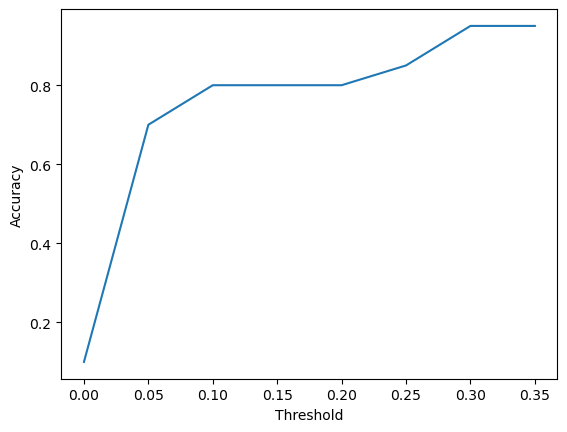

In [13]:
a = np.arange(10).reshape(10, 1)
correct_classifications = np.hstack((a,a))
accuracy=[]
for i in range(8):
    pruning_result=Pruning_recognition(template_feature_matrix,0.05*i)
    differing_positions = pruning_result != correct_classifications
    accuracy.append(1-np.sum(differing_positions)/20)
x = np.linspace(0.0,0.05*7,num=8)

plt.plot(x, accuracy)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.show()

The best threshold is 0.3

## 5. Multiple template

## Template Averaging

In [14]:
def Template_Averaging(templates):
    master=templates[0]
    for i in range(1,len(templates)):
        path=DTW_template_averaging(master,template[i])

## Use DTW to align master template and other templates

In [230]:
def DTW_template_averaging(input,template):      
    previous_matrix=[[(-1,-1) for j in range(len(template))]for i in range(len(input))]
    new_array=np.full(len(template),np.inf)
    old_array=np.full(len(template),np.inf)
    for i in range(len(input)):
        if i==0:
            old_array[0]=euclidean_distance(input[i],template[0])
        else:
            for j in range(len(template)):
                if j==0:
                    new_array[0]=old_array[0]+euclidean_distance(input[i], template[j])
                    previous_matrix[i][j]=(i-1,0)
                elif j==1:
                    cost=min(old_array[j-1],old_array[j])
                    if cost!=np.inf:
                        if cost==old_array[j-1]: previous_matrix[i][j]=(i-1,j-1)
                        else: previous_matrix[i][j]=(i-1,j)
                    new_array[1]=euclidean_distance(input[i],template[j])+cost
                else:
                    cost=min(old_array[j-1],old_array[j-2],old_array[j])
                    if cost!=np.inf:
                        if cost==old_array[j-1]: previous_matrix[i][j]=(i-1,j-1)
                        elif cost==old_array[j-2]: previous_matrix[i][j]=(i-1,j-2)
                        else: previous_matrix[i][j]=(i-1,j)
                    new_array[j]=euclidean_distance(input[i],template[j])+cost
            old_array=new_array
            new_array=np.full(len(template),np.inf)
    path=[]
    transition_type=[]
    previous_point=previous_matrix[len(input)-1][len(template)-1]
    
    i=len(input)
    if previous_point[1]==len(template)-1:
        transition_type.append(0)
    elif previous_point[1]==len(template)-2:
        transition_type.append(1)
    else:
        transition_type.append(2) 
    while i>1 :
        path.append(previous_point)
        current=previous_point
        previous_point=previous_matrix[previous_point[0]][previous_point[1]]
        if current[1]==previous_point[1]:
           transition_type.append(0)
        elif current[1]==previous_point[1]+1:
            transition_type.append(1)
        else:
            transition_type.append(2)
        i-=1
    # print(path)
    return np.flip(transition_type[:-1])

In [236]:
def get_transition_type(index,num):
    template=get_cepstrum_features(str(index)+'_template.wav')
    type=[]
    alignment=template
    count=np.full(len(alignment),1)
    for i in range(1,num+1):
        input=get_cepstrum_features(str(index)+'_training_'+str(i)+'.wav')
        curr_type=DTW_template_averaging(input,template)
        type.append(curr_type)
        # align the template and input by the trasition types
        k=0
        j=0
        m=0
        alignment[0]+=input[0]
        count[0]+=1
        while m<len(curr_type):
            if curr_type[m]==1:
                k+=1
                j+=1
            elif curr_type[m]==2:
                j+=1
                k+=2
            else:
                j+=1
            alignment[k]+=input[j]
            count[k]+=1
            m+=1       
    return alignment,count

In [245]:
alignment,count=get_transition_type(1,3)
count = count[:, np.newaxis]
averaged_template=alignment/count

In [249]:
input=get_cepstrum_features('1_training_4.wav')
template=get_cepstrum_features('1_template.wav')

## Test by DTW

## Test by Time Synchronous DTW

## Test by pruning

# Problem 2

## Training an HMM

In [ ]:
# negative log Gaussian
def log_Gaussian(m, sigma_square, x):
    left=0.5*np.sum(np.log(2*np.pi*sigma_square))
    right=0.5*np.sum(np.square((x-m))/sigma_square)
    return left+right

In [ ]:
def HMM_DTW(data,state):
    for i in range(data):
        template=data[i]
        

In [343]:
def Training_HMM(data,state=5):
    # calculate the initial boundaries for each state in each template
    def initialize_boundary(data,state=5):
        boundary=[[(0,0)for j in range(state)]for i in range(len(data))]
        for i in range(state):
            length=round(len(data[i])/5)
            for j in range(state):
                if j==0:
                    boundary[i][j]=(0,(j+1)*length)
                elif j==state-1:
                    boundary[i][j]=(j*length,len(data[i]))
                else:
                    boundary[i][j]=(j*length,(j+1)*length)
        return boundary
            
    # calculate state means and covarriances        
    def MeanAndVar(data,boundary,state=5):
        means=[]
        covs=[]
        nodes=[[] for i in range(len(boundary))]#record nodes in different states
        for i in range(len(boundary)):
            for j in range(state):
                low=boundary[i][j][0]
                high=boundary[i][j][1]
                for k in range(low,high):
                    nodes[j].append(data[i][k])
        for i in range(state):
            mean=np.mean(nodes[i],0)
            means.append(mean)
            node=np.array(nodes[i])
            cov=np.cov(np.array(node).T)
            cov=np.diagonal(cov, offset=0, axis1=0, axis2=1)
            covs.append(cov)
        return means,covs
        
    # compute transition scores according to the boundary matrix
    def TransitionScore(boundary,state=5):
        states=np.zeros(state)
        for i in range(len(boundary)):
            for j in range(state):
                num_of_nodes=boundary[i][j][1]-boundary[i][j][0]
                states[j]+=num_of_nodes
        score=np.full((state,state),-np.inf)
        score[0][1]=-np.log(1)
        for i in range(1,state):
            for j in range(state):
                if i==j:
                    score[i][j]=-np.log((states[i]-state)/states[i])
                elif i==j-1:
                    score[i][j]=-np.log(state/states[i])
        return score

In [344]:
data=[]
data.append(get_cepstrum_features('1_template.wav'))
for i in range(1,5):
    data.append(get_cepstrum_features('1_training_'+str(i)+'.wav'))
print(round(len(data[0])/5))
boundary=initialize_boundary(data)
mean,cov=MeanAndVar(data,boundary)
print(boundary,np.shape(mean),np.shape(cov))
score=TransitionScore(boundary)
print(score)

14
[[(0, 14), (14, 28), (28, 42), (42, 56), (56, 69)], [(0, 30), (30, 60), (60, 90), (90, 120), (120, 149)], [(0, 30), (30, 60), (60, 90), (90, 120), (120, 149)], [(0, 24), (24, 48), (48, 72), (72, 96), (96, 119)], [(0, 20), (20, 40), (40, 60), (60, 80), (80, 99)]] (5, 13) (5, 13)
[[       -inf -0.                -inf        -inf        -inf]
 [       -inf  0.04329681  3.16124671        -inf        -inf]
 [       -inf        -inf  0.04329681  3.16124671        -inf]
 [       -inf        -inf        -inf  0.04329681  3.16124671]
 [       -inf        -inf        -inf        -inf  0.04525659]]


In [303]:
np.mean([[1,2,3],[2,3,4]],0)

array([1.5, 2.5, 3.5])